# 시계열 데이터에 RNN 적용하기  

시간에 따른 온도 예측 문제를 해결하면서 RNN에 사용할 수 있는 다른 기법들을 살펴본다.

In [1]:
import os

data_dir = './datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname, 'r') as f:
    data = f.read()
    
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [4]:
from matplotlib import rc 
rc('font',family='AppleGothic')

/Users/nahyeonan/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/nahyeonan/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


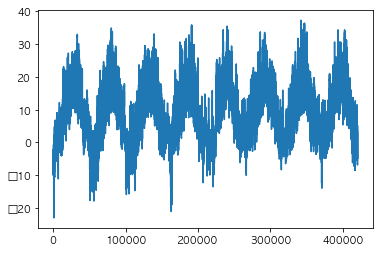

In [5]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

In [6]:
float_data[0]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

In [8]:
lines[0].split(",")

['01.01.2009 00:10:00',
 '996.52',
 '-8.02',
 '265.40',
 '-8.90',
 '93.30',
 '3.33',
 '3.11',
 '0.22',
 '1.94',
 '3.12',
 '1307.75',
 '1.03',
 '1.75',
 '152.30']

/Users/nahyeonan/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/nahyeonan/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


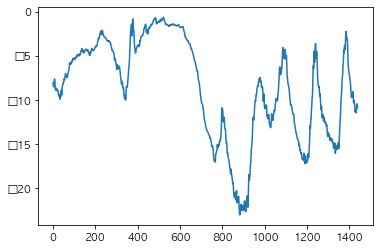

In [9]:
plt.plot(range(1440), temp[:1440])

## 데이터 준비

**<문제 정의>**  
lookback 타임스텝 만큼 이전으로 돌아가서 매 steps 타임스텝마다 샘플링.  
이를 바탕으로 delay 타임스텝 이후의 온도를 예측하자  

하나의 타임스텝 = 10분  
lookback 타임스텝 = 1440 (10일) : 10일 전 데이터로 돌아감  
steps = 6 : 1시간마다 데이터 포인트 하나를 샘플링  
delay = 144 : 24시간이 지난 데이터가 타깃  

**전처리 : 특성별 평균을 빼고 표준편차로 나누기**

In [10]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [11]:
float_data[0]

array([ 0.90014748, -1.93135845, -1.98211036, -1.86280029,  1.07285236,
       -1.30742164, -1.47375773, -0.79868641, -1.4762674 , -1.47815522,
        2.12375056, -0.72950452, -0.78067973, -0.27613603])

**전처리 : 데이터 샘플 배치와 매치되는 타겟을 반환하는 제너레이터**

In [14]:
def generator(data, lookback, delay, min_index, max_index,
             shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows),
                          lookback // step,
                          data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [15]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data, 
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

# 추출 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

#### 기준점 만들기 
: 24시간 후의 온도는 지금과 동일하다.  

In [16]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2900256435492456


In [17]:
celsius_mae = 0.29 * std[1]

In [18]:
celsius_mae

2.5672247338393395

<hr>

### 기본 방법
간단한 네트워크를 먼저 만드는 것이 좋다.  
여기서는 dense 를 이용한 완전 연결 네트워크를 만들어보자 

In [19]:
float_data.shape

(420451, 14)

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                   steps_per_epoch=500,
                   epochs=20,
                   validation_data=val_gen,
                   validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 10s 18ms/step - loss: 2.2301 - val_loss: 0.9782
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.7375 - val_loss: 0.3643
Epoch 3/20
500/500 [==============================] - 9s 17ms/step - loss: 0.3468 - val_loss: 0.3243
Epoch 4/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2750 - val_loss: 0.3187
Epoch 5/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2593 - val_loss: 0.3236
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2502 - val_loss: 0.3023
Epoch 7/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2415 - val_loss: 0.3134
Epoch 8/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2345 - val_loss: 0.3135
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2272 - val_loss: 0.3779
Epoch 10/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2260 - val_l

### 결과 그래프 그리기

In [21]:
import matplotlib.pyplot as plt

def drawHistory(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.figure()
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

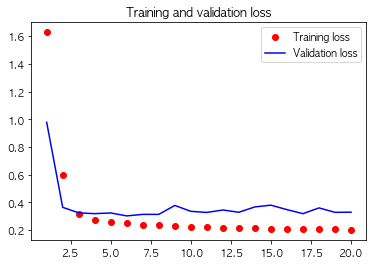

In [22]:
drawHistory(history)

이 모델의 검증 손실점수는 0.3 이상으로 기준점보다 안 좋은 성능을 낸다.  

## 첫 번째 순환 신경망 : GRU

In [23]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, 
                    steps_per_epoch=500, 
                    epochs=20, 
                    validation_data=val_gen, 
                    validation_steps=val_steps,
                    verbose=2)

Epoch 1/20
500/500 - 44s - loss: 0.3004 - val_loss: 0.2701
Epoch 2/20
500/500 - 43s - loss: 0.2802 - val_loss: 0.2695
Epoch 3/20
500/500 - 45s - loss: 0.2747 - val_loss: 0.2651
Epoch 4/20
500/500 - 42s - loss: 0.2691 - val_loss: 0.2672
Epoch 5/20
500/500 - 42s - loss: 0.2642 - val_loss: 0.2688
Epoch 6/20
500/500 - 43s - loss: 0.2599 - val_loss: 0.2629
Epoch 7/20
500/500 - 43s - loss: 0.2547 - val_loss: 0.2656
Epoch 8/20
500/500 - 44s - loss: 0.2519 - val_loss: 0.2731
Epoch 9/20
500/500 - 44s - loss: 0.2469 - val_loss: 0.2726
Epoch 10/20
500/500 - 43s - loss: 0.2407 - val_loss: 0.2815
Epoch 11/20
500/500 - 42s - loss: 0.2350 - val_loss: 0.2778
Epoch 12/20
500/500 - 41s - loss: 0.2318 - val_loss: 0.2815
Epoch 13/20
500/500 - 41s - loss: 0.2267 - val_loss: 0.2830
Epoch 14/20
500/500 - 41s - loss: 0.2228 - val_loss: 0.2849
Epoch 15/20
500/500 - 42s - loss: 0.2201 - val_loss: 0.2907
Epoch 16/20
500/500 - 42s - loss: 0.2155 - val_loss: 0.2933
Epoch 17/20
500/500 - 41s - loss: 0.2121 - val_lo

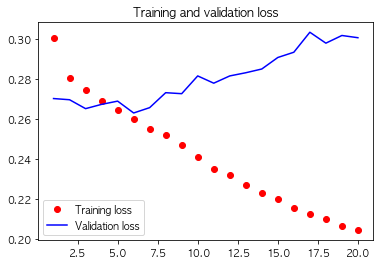

In [24]:
drawHistory(history)

<hr>

### 드롭아웃을 추가한 GRU 모델

순환 신경망에서 드롭아웃을 올바르게 적용하는 방법  
: 동일한 유닛의 드롭 패턴을 모든 타임스텝에 적용해야 함  

In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2, 
                     recurrent_dropout=0.2, 
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, 
                    steps_per_epoch=500, 
                    epochs=40, 
                    validation_data=val_gen, 
                    validation_steps=val_steps,
                    verbose=2)

Epoch 1/40
500/500 - 68s - loss: 0.3237 - val_loss: 0.2830
Epoch 2/40
500/500 - 67s - loss: 0.3066 - val_loss: 0.2795
Epoch 3/40
500/500 - 68s - loss: 0.2998 - val_loss: 0.2769
Epoch 4/40
500/500 - 68s - loss: 0.2949 - val_loss: 0.2754
Epoch 5/40
500/500 - 66s - loss: 0.2919 - val_loss: 0.2701
Epoch 6/40
500/500 - 67s - loss: 0.2854 - val_loss: 0.2700
Epoch 7/40
500/500 - 66s - loss: 0.2815 - val_loss: 0.2769
Epoch 8/40
500/500 - 65s - loss: 0.2780 - val_loss: 0.2707
Epoch 9/40
500/500 - 65s - loss: 0.2754 - val_loss: 0.2807
Epoch 10/40
500/500 - 68s - loss: 0.2716 - val_loss: 0.2711
Epoch 11/40
500/500 - 69s - loss: 0.2695 - val_loss: 0.2696
Epoch 12/40
500/500 - 70s - loss: 0.2650 - val_loss: 0.2733
Epoch 13/40
500/500 - 66s - loss: 0.2640 - val_loss: 0.2746
Epoch 14/40
500/500 - 65s - loss: 0.2619 - val_loss: 0.2728
Epoch 15/40
500/500 - 65s - loss: 0.2582 - val_loss: 0.2743
Epoch 16/40
500/500 - 65s - loss: 0.2549 - val_loss: 0.2810
Epoch 17/40
500/500 - 65s - loss: 0.2544 - val_lo

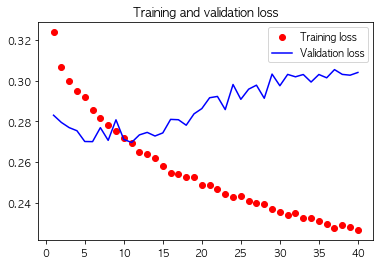

In [27]:
drawHistory(history)

<hr>

### 스태킹 순환층

네트워크의 용량을 늘린다.  
- 층의 유닛 수를 늘린다.
- 층을 추가한다. 

드롭아웃까지 적용한 후 과대적합이 일어날 때까지 용량을 늘리는 것이 좋다.  

순환 층을 차례로 쌓을 때 모든 중간층은 전체 시퀀스 (3D 텐서)를 출력해야 한다.  
(keras에서는 return_sequences 파라미터를 true로 지정한다.)

In [28]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.1, 
                     recurrent_dropout=0.5, 
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, 
                     activation='relu', 
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, 
                    steps_per_epoch=500, 
                    epochs=40, 
                    validation_data=val_gen, 
                    validation_steps=val_steps,
                    verbose=2)

Epoch 1/40
500/500 - 171s - loss: 0.3238 - val_loss: 0.2819
Epoch 2/40
500/500 - 166s - loss: 0.3035 - val_loss: 0.2798
Epoch 3/40
500/500 - 168s - loss: 0.2943 - val_loss: 0.2698
Epoch 4/40
500/500 - 166s - loss: 0.2872 - val_loss: 0.2775
Epoch 5/40
500/500 - 172s - loss: 0.2791 - val_loss: 0.2800
Epoch 6/40
500/500 - 171s - loss: 0.2761 - val_loss: 0.2735
Epoch 7/40
500/500 - 164s - loss: 0.2715 - val_loss: 0.2726
Epoch 8/40
500/500 - 165s - loss: 0.2672 - val_loss: 0.2732
Epoch 9/40
500/500 - 165s - loss: 0.2631 - val_loss: 0.2754
Epoch 10/40
500/500 - 164s - loss: 0.2582 - val_loss: 0.2865
Epoch 11/40
500/500 - 164s - loss: 0.2545 - val_loss: 0.3027
Epoch 12/40
500/500 - 164s - loss: 0.2502 - val_loss: 0.2914
Epoch 13/40
500/500 - 164s - loss: 0.2485 - val_loss: 0.2993
Epoch 14/40
500/500 - 164s - loss: 0.2426 - val_loss: 0.2955
Epoch 15/40
500/500 - 163s - loss: 0.2380 - val_loss: 0.2937
Epoch 16/40
500/500 - 163s - loss: 0.2331 - val_loss: 0.3070
Epoch 17/40
500/500 - 164s - loss

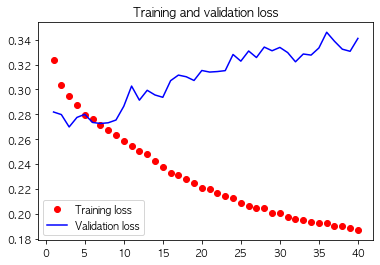

In [29]:
drawHistory(history)

<hr>

### 양방향 RNN (Bidirectional RNN) 사용하기

자연어 처리에서 자주 사용된다.  

#### 온도 예측 문제

In [30]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])
))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, 
                    steps_per_epoch=500, 
                    epochs=40, 
                    validation_data=val_gen, 
                    validation_steps=val_steps,
                    verbose=2)

Epoch 1/40
500/500 - 58s - loss: 0.2994 - val_loss: 0.2741
Epoch 2/40
500/500 - 57s - loss: 0.2756 - val_loss: 0.2631
Epoch 3/40
500/500 - 56s - loss: 0.2669 - val_loss: 0.2665
Epoch 4/40
500/500 - 55s - loss: 0.2615 - val_loss: 0.2682
Epoch 5/40
500/500 - 56s - loss: 0.2560 - val_loss: 0.2660
Epoch 6/40
500/500 - 55s - loss: 0.2506 - val_loss: 0.2693
Epoch 7/40
500/500 - 55s - loss: 0.2442 - val_loss: 0.2753
Epoch 8/40
500/500 - 55s - loss: 0.2380 - val_loss: 0.2733
Epoch 9/40
500/500 - 56s - loss: 0.2317 - val_loss: 0.2737
Epoch 10/40
500/500 - 56s - loss: 0.2256 - val_loss: 0.2807
Epoch 11/40
500/500 - 55s - loss: 0.2178 - val_loss: 0.2810
Epoch 12/40
500/500 - 55s - loss: 0.2142 - val_loss: 0.2848
Epoch 13/40
500/500 - 56s - loss: 0.2059 - val_loss: 0.3021
Epoch 14/40
500/500 - 57s - loss: 0.2004 - val_loss: 0.2927
Epoch 15/40
500/500 - 56s - loss: 0.1959 - val_loss: 0.2925
Epoch 16/40
500/500 - 56s - loss: 0.1905 - val_loss: 0.2948
Epoch 17/40
500/500 - 56s - loss: 0.1864 - val_lo

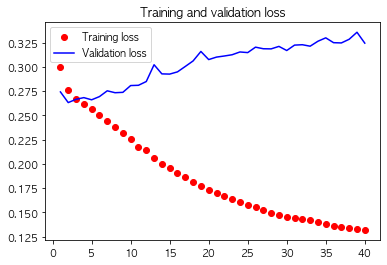

In [31]:
drawHistory(history)

#### IMDB 예제에 적용하기

*아래는 텍스트의 단어를 거꾸로 뒤집은뒤 순환 신경망으로 처리할 때 결과가 달라지는가를 보기 위한 코드*

텍스트 데이터에 대해 순서를 뒤집어서 처리하는 것은 시간순서대로 처리하는 것과 동일하게 잘 작동한다.  
(언어를 이해하는 데 단어의 순서가 결정적이지 않다는 가정을 지지함)

In [32]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2,
                    verbose=2)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/nahyeonan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/nahyeonan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If

Epoch 1/10
157/157 - 45s - loss: 0.4786 - acc: 0.7746 - val_loss: 0.6783 - val_acc: 0.7492
Epoch 2/10
157/157 - 43s - loss: 0.3134 - acc: 0.8805 - val_loss: 0.3373 - val_acc: 0.8634
Epoch 3/10
157/157 - 43s - loss: 0.2522 - acc: 0.9069 - val_loss: 0.3238 - val_acc: 0.8662
Epoch 4/10
157/157 - 42s - loss: 0.2204 - acc: 0.9208 - val_loss: 0.4308 - val_acc: 0.8338
Epoch 5/10
157/157 - 42s - loss: 0.1881 - acc: 0.9342 - val_loss: 0.3508 - val_acc: 0.8634
Epoch 6/10
157/157 - 42s - loss: 0.1713 - acc: 0.9417 - val_loss: 0.5781 - val_acc: 0.8452
Epoch 7/10
157/157 - 43s - loss: 0.1552 - acc: 0.9474 - val_loss: 0.3673 - val_acc: 0.8800
Epoch 8/10
157/157 - 43s - loss: 0.1447 - acc: 0.9535 - val_loss: 0.3968 - val_acc: 0.8770
Epoch 9/10
157/157 - 43s - loss: 0.1323 - acc: 0.9549 - val_loss: 0.4233 - val_acc: 0.8510
Epoch 10/10
157/157 - 43s - loss: 0.1245 - acc: 0.9579 - val_loss: 0.4002 - val_acc: 0.8722


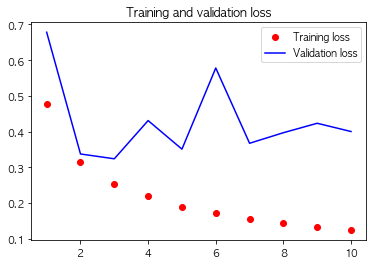

In [33]:
drawHistory(history)

*이제 양방향 LSTM을 이용하여 imdb를 분석해보자*

양방향 RNN 은 Bidirectional() 층으로 만든다.  
첫번째 변수로 순환층 객체를 받는다.  
전달받은 순환층으로 하나는 시간 순서대로 입력 시퀀스를 처리하도록 만들고, 두번째는 반대 순서로 입력 시퀀스를 처리하도록 만든다.  
이 두 순환층의 결과를 합쳐서 결과를 낸다.  

In [34]:
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2,
                    verbose=2)

Epoch 1/10
157/157 - 69s - loss: 0.5161 - acc: 0.7534 - val_loss: 0.3908 - val_acc: 0.8444
Epoch 2/10
157/157 - 65s - loss: 0.3300 - acc: 0.8707 - val_loss: 0.3285 - val_acc: 0.8766
Epoch 3/10
157/157 - 65s - loss: 0.2653 - acc: 0.9018 - val_loss: 0.3689 - val_acc: 0.8436
Epoch 4/10
157/157 - 65s - loss: 0.2291 - acc: 0.9197 - val_loss: 0.3595 - val_acc: 0.8756
Epoch 5/10
157/157 - 65s - loss: 0.1941 - acc: 0.9302 - val_loss: 0.4194 - val_acc: 0.8388
Epoch 6/10
157/157 - 65s - loss: 0.1740 - acc: 0.9392 - val_loss: 0.3814 - val_acc: 0.8746
Epoch 7/10
157/157 - 65s - loss: 0.1535 - acc: 0.9464 - val_loss: 0.4100 - val_acc: 0.8650
Epoch 8/10
157/157 - 65s - loss: 0.1433 - acc: 0.9498 - val_loss: 0.4037 - val_acc: 0.8656
Epoch 9/10
157/157 - 65s - loss: 0.1331 - acc: 0.9564 - val_loss: 0.4075 - val_acc: 0.8652
Epoch 10/10
157/157 - 65s - loss: 0.1157 - acc: 0.9600 - val_loss: 0.7690 - val_acc: 0.7904


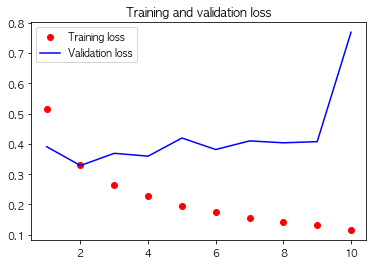

In [35]:
drawHistory(history)